In [1]:
# import CNN package
import tensorflow as tf

# import plot related functions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# dataset related packages
from tensorflow.examples.tutorials.mnist import input_data

/home/amd_3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


%%HTML
<ul>
<li> The data is already standardized to fall in the range 0.0 to 1.0 </li>
</ul>

# UTIL functions

In [3]:
def plot_loss_curve(train_metric_list, val_metric_list):
    
    # get x-label list
    epcoh_list = range(1, len(train_metric_list) + 1 )
    
    # get train_accuracy data
    train_acc_list = [ item[1] for item in train_metric_list]
    
    # get validation accuracy data
    val_acc_list = [ item[1] for item in val_metric_list]
    
    # plot both train, validation curve
    plt.plot(epcoh_list, train_acc_list, label='Train Loss', color='r')
    plt.plot(epcoh_list, val_acc_list, label='Validation Loss', color='b')
    plt.xlabel('Training Epoch')
    plt.ylabel('Cross Entropy Error')
    plt.title('Training Loss Vs Validation Loss')
    plt.legend()
    plt.show()

In [4]:
def plot_accuracy_curve(train_metric_list, val_metric_list):
    
    # get x-label list
    epcoh_list = range(1, len(train_metric_list) + 1 )
    
    # get train_accuracy data
    train_acc_list = [ item[2] for item in train_metric_list]
    
    # get validation accuracy data
    val_acc_list = [ item[2] for item in val_metric_list]
    
    # plot both train, validation curve
    plt.plot(epcoh_list, train_acc_list, label='Train Accuracy', color='r')
    plt.plot(epcoh_list, val_acc_list, label='Validation Accuracy', color='b')
    plt.xlabel('Training Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Vs Validation Accuracy')
    plt.legend()
    plt.show()

# MODELS

In [5]:
# declare placeholders for input and output
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)

In [6]:
X_test = mnist.test.images.reshape(mnist.test.images.shape[0], 28, 28, 1)

In [7]:
def train_and_evaluate_model(custom_model, keep_prob_val, num_epochs = 2):
    
    """
    This function train and evaluate the CNN model
    """

    batch_size = 100
    total_batchs = int(mnist.train.num_examples / batch_size)
    
    # define the loss function
    cee = tf.reduce_mean(-tf.reduce_sum(y * tf.log(custom_model), reduction_indices=[1]))
    # defien the train step
    train_step = tf.train.AdamOptimizer(1e-03).minimize(cee)
    # define the accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1), tf.argmax(custom_model,1)), tf.float32)) * 100.0
    

    # declare two list for holding loss, accuracy for both train, validation
    train_metric_list = list()
    val_metric_list = list()

    # create a session and execute the code
    with tf.Session() as sess:

        # initialize variables
        tf.global_variables_initializer().run()

        # run multiple epochs
        for epoch in range(1, num_epochs + 1):

            # run batch by batch
            for batch_id in range(total_batchs):

                # get the train data into features and labels
                X_train, y_train = mnist.train.next_batch(batch_size)
                X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

                # run the training
                _ = sess.run([train_step], feed_dict={X:X_train, y:y_train, keep_prob : keep_prob_val})


            # find predicted value, loss and accuracy for both train &test data sets
            X_train = mnist.train.images.reshape(mnist.train.images.shape[0], 28, 28, 1)
            tr_pred, tr_cee, tr_acc = sess.run([custom_model, cee, accuracy], feed_dict={X:X_train, 
                                                                               y:mnist.train.labels,
                                                                               keep_prob : 1.0})
            train_metric_list.append((tr_pred, tr_cee, tr_acc,))


            X_val = mnist.validation.images.reshape(mnist.validation.images.shape[0], 28, 28, 1)
            val_pred, val_cee, val_acc = sess.run([custom_model, cee, accuracy], feed_dict={X:X_val,
                                                                                  y:mnist.validation.labels,
                                                                                  keep_prob : 1.0})
            val_metric_list.append((val_pred, val_cee, val_acc,))
            
        # Test the model
        ts_pred, ts_cee, ts_acc = sess.run([custom_model, cee, accuracy], feed_dict={X : X_test,
                                                                          y : mnist.test.labels,
                                                                          keep_prob : 1.0})
        test_loss = ts_cee.mean()
        
        print('Test accuracy of model :%f, Test loss:%f'%(ts_acc, test_loss,))
        
        
            
            
    return (test_loss, ts_acc, train_metric_list, val_metric_list,)

## a) CNN Model a - 3 Convs layers, 2 FC layers, Softmax 

In [8]:
def build_model_a(X):
    """
    This function defines an architecture for model
    """
    
    # =============================== Conv layer 1 ===================================================

    # define filter and bias for each filter at layer 1
    filter_l1 = tf.Variable(tf.truncated_normal(shape=[5,5,1,12], stddev=0.1))
    bias_l1 = tf.Variable(tf.truncated_normal(shape=[12], stddev=0.1))

    # compute convolved output and actiation map for layer 1
    conv_out_1 = tf.nn.conv2d(X, filter_l1, strides=[1, 2, 2, 1], padding='SAME') + bias_l1
    act_map_1 = tf.nn.relu(conv_out_1)
    
    print('Activation map 1', act_map_1)
    
    
    # ============================== Conv layer 2 ===================================================
    # define filter and bias for each filter at layer 2
    filter_l2 = tf.Variable(tf.truncated_normal(shape=[3,3,12, 8], stddev=0.1))
    bias_l2 = tf.Variable(tf.truncated_normal(shape=[8], stddev=0.1))

    # compute convolved output and actiation map for layer 2
    conv_out_2 = tf.nn.conv2d(act_map_1, filter_l2, strides=[1, 2, 2, 1], padding='VALID') + bias_l2
    act_map_2 = tf.nn.relu(conv_out_2)
    
    print('Activation map 2', act_map_2)
    
    # ============================== Conv layer 3 ===================================================

    # define filter and bias for each filter at layer 2
    filter_l3 = tf.Variable(tf.truncated_normal(shape=[2,2,8, 6], stddev=0.1))
    bias_l3 = tf.Variable(tf.truncated_normal(shape=[6], stddev=0.1))

    # compute convolved output and actiation map for layer 2
    conv_out_3 = tf.nn.conv2d(act_map_2, filter_l3, strides=[1, 2, 2, 1], padding='VALID') + bias_l3
    act_map_3 = tf.nn.relu(conv_out_3)
    
    print('Activation map 3', act_map_3)
    #=================================================================================================
    
    
    # =============================== bottleneck layer ===============================================
    bottle_neck_layer = tf.reshape(act_map_3, [-1, 54])
    
    
    # ============================= FC 1 =============================================================
    weight_fc_1 = tf.Variable(tf.truncated_normal(shape=[54, 28], stddev=0.1))
    bias_fc_1 = tf.Variable(tf.truncated_normal(shape=[28], stddev=0.1))
    # compute net ninput for FC1
    net_input_fc_1 = tf.matmul(bottle_neck_layer, weight_fc_1) +  bias_fc_1
    # compute activation
    output_fc_1 = tf.nn.relu(net_input_fc_1)
    
    # ============================ FC 2 =============================================================
    weight_fc_2 = tf.Variable(tf.truncated_normal(shape=[28, 10], stddev=0.1))
    bias_fc_2 = tf.Variable(tf.truncated_normal(shape=[10], stddev=0.1))
    # compute net ninput for FC1
    net_input_fc_2 = tf.matmul(output_fc_1, weight_fc_2) +  bias_fc_2
    #=================================================================================================
    
    # ================================== Softmax layer ===============================================
    y_ = tf.nn.softmax(net_input_fc_2)
    
    return y_

Activation map 1 Tensor("Relu:0", shape=(?, 14, 14, 12), dtype=float32)
Activation map 2 Tensor("Relu_1:0", shape=(?, 6, 6, 8), dtype=float32)
Activation map 3 Tensor("Relu_2:0", shape=(?, 3, 3, 6), dtype=float32)
Test accuracy of model :97.470001, Test loss:0.083423


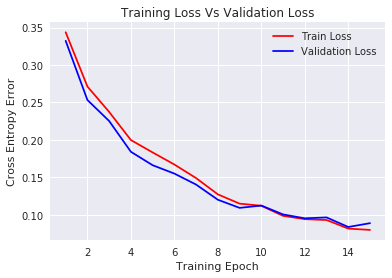

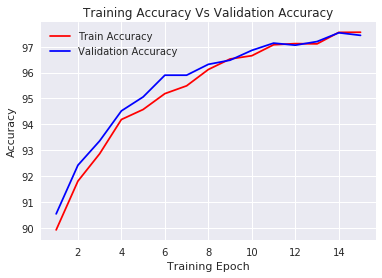

In [9]:
# buid the model a
cnn_a = build_model_a(X) 

# train and evaluate the model
keep_prob_val = 1.0 # for dropout rate
num_epochs = 15
ts_loss_cnn_a, ts_acc_cnn_a, train_metric_list, val_metric_list = train_and_evaluate_model(cnn_a , keep_prob_val,
                                                                                           num_epochs)

# plot the loss curve
plot_loss_curve(train_metric_list, val_metric_list)
# plot the accuracy curve
plot_accuracy_curve(train_metric_list, val_metric_list)

## b) 4-Convs Layers, Dropout layer,  FC layers, Softmax

In [10]:
def build_model_b(X):
    
    """
    This function defines an architecture for model
    """
    
    # Conv layer 1

    # define filter and bias for each filter at layer 1
    filter_l1 = tf.Variable(tf.truncated_normal(shape=[3,3,1,16], stddev=0.1))
    bias_l1 = tf.Variable(tf.truncated_normal(shape=[16], stddev=0.1))

    # compute convolved output and actiation map for layer 1
    conv_out_1 = tf.nn.conv2d(X, filter_l1, strides=[1, 2, 2, 1], padding='SAME') + bias_l1
    act_map_1 = tf.nn.relu(conv_out_1) 
    
    print('Activation map 1', act_map_1)
    
    
    # =============================== Conv layer 2 ==================================================
    # define filter and bias for each filter at layer 2
    filter_l2 = tf.Variable(tf.truncated_normal(shape=[2,2,16, 10], stddev=0.1))
    bias_l2 = tf.Variable(tf.truncated_normal(shape=[10], stddev=0.1))

    # compute convolved output and actiation map for layer 2
    conv_out_2 = tf.nn.conv2d(act_map_1, filter_l2, strides=[1, 2, 2, 1], padding='SAME') + bias_l2
    act_map_2 = tf.nn.relu(conv_out_2)
    
    print('Activation map 2', act_map_2)
    
    # =============================== Conv layer 3 ==================================================

    # define filter and bias for each filter at layer 2
    filter_l3 = tf.Variable(tf.truncated_normal(shape=[2,2,10, 8], stddev=0.1))
    bias_l3 = tf.Variable(tf.truncated_normal(shape=[8], stddev=0.1))

    # compute convolved output and actiation map for layer 2
    conv_out_3 = tf.nn.conv2d(act_map_2, filter_l3, strides=[1, 2, 2, 1], padding='SAME') + bias_l3
    act_map_3 = tf.nn.relu(conv_out_3)
    
    print('Activation map 3', act_map_3)
    # =============================== Conv layer 4 =================================================

    # define filter and bias for each filter at layer 2
    filter_l4 = tf.Variable(tf.truncated_normal(shape=[2,2,8, 6], stddev=0.1))
    bias_l4 = tf.Variable(tf.truncated_normal(shape=[6], stddev=0.1))

    # compute convolved output and actiation map for layer 2
    conv_out_4 = tf.nn.conv2d(act_map_3, filter_l4, strides=[1, 2, 2, 1], padding='SAME') + bias_l4
    act_map_4 = tf.nn.relu(conv_out_4)
    
    print('Activation map 4', act_map_4)
    
    # flatten the output for creating bottleneck layer
    bottle_neck_layer = tf.reshape(act_map_4, [-1, 24])
    
    
    # ==================================== FC 1 ====================================================
    weight_fc_1 = tf.Variable(tf.truncated_normal(shape=[24, 18], stddev=0.1))
    bias_fc_1 = tf.Variable(tf.truncated_normal(shape=[18], stddev=0.1))
    # compute net ninput for FC1
    net_input_fc_1 = tf.matmul(bottle_neck_layer, weight_fc_1) +  bias_fc_1
    # compute activation
    output_fc_1 = tf.nn.relu(net_input_fc_1)
    # dropout layer
    output_fc_1 = tf.nn.dropout(output_fc_1, keep_prob)
    # =================================== FC 2 ======================================================
    weight_fc_2 = tf.Variable(tf.truncated_normal(shape=[18, 10], stddev=0.1))
    bias_fc_2 = tf.Variable(tf.truncated_normal(shape=[10], stddev=0.1))
    # compute net ninput for FC1
    net_input_fc_2 = tf.matmul(output_fc_1, weight_fc_2) +  bias_fc_2
    #=================================================================================================
    
    
    # ================================== Softmax layer ===============================================
    y_ = tf.nn.softmax(net_input_fc_2)
    
    return y_

Activation map 1 Tensor("Relu_4:0", shape=(?, 14, 14, 16), dtype=float32)
Activation map 2 Tensor("Relu_5:0", shape=(?, 7, 7, 10), dtype=float32)
Activation map 3 Tensor("Relu_6:0", shape=(?, 4, 4, 8), dtype=float32)
Activation map 4 Tensor("Relu_7:0", shape=(?, 2, 2, 6), dtype=float32)
Test accuracy of model :95.820000, Test loss:0.138289


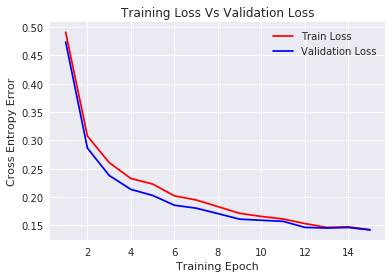

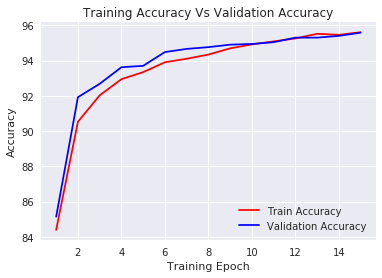

In [11]:
# buid the model b
cnn_b = build_model_b(X)

# train and evaluate the model
keep_prob_val = 0.95 # for dropout rate
num_epochs = 15

ts_loss_cnn_b, ts_acc_cnn_b, train_metric_list, val_metric_list = train_and_evaluate_model(cnn_b, keep_prob_val, 
                                                                                           num_epochs)

# plot the loss curve
plot_loss_curve(train_metric_list, val_metric_list)
# plot the accuracy curve
plot_accuracy_curve(train_metric_list, val_metric_list)

## c) CNN Model 4 -Conv Layer, Dropout, Batch Norm, FC, Softmax

In [12]:
def build_model_c(X):
    
    """
    This function defines an architecture for model
    """
    
    # Conv layer 1

    # define filter and bias for each filter at layer 1
    filter_l1 = tf.Variable(tf.truncated_normal(shape=[3,3,1,16], stddev=0.1))
    bias_l1 = tf.Variable(tf.truncated_normal(shape=[16], stddev=0.1))

    # compute convolved output and actiation map for layer 1
    conv_out_1 = tf.nn.conv2d(X, filter_l1, strides=[1, 2, 2, 1], padding='SAME') + bias_l1
    act_map_1 = tf.nn.relu(conv_out_1) 
    
    print('Activation map 1', act_map_1)
    
    # =============================== Conv layer 2 ==================================================
    # define filter and bias for each filter at layer 2
    filter_l2 = tf.Variable(tf.truncated_normal(shape=[3,3,16, 10], stddev=0.1))
    bias_l2 = tf.Variable(tf.truncated_normal(shape=[10], stddev=0.1))

    # compute convolved output and actiation map for layer 2
    conv_out_2 = tf.nn.conv2d(act_map_1, filter_l2, strides=[1, 2, 2, 1], padding='SAME') + bias_l2
    act_map_2 = tf.nn.relu(conv_out_2)
    
    print('Activation map 2', act_map_2)
    
    # =============================== Conv layer 3 ==================================================

    # define filter and bias for each filter at layer 2
    filter_l3 = tf.Variable(tf.truncated_normal(shape=[2,2,10, 8], stddev=0.1))
    bias_l3 = tf.Variable(tf.truncated_normal(shape=[8], stddev=0.1))

    # compute convolved output and actiation map for layer 2
    conv_out_3 = tf.nn.conv2d(act_map_2, filter_l3, strides=[1, 2, 2, 1], padding='SAME') + bias_l3
    act_map_3 = tf.nn.relu(conv_out_3)
    
    print('Activation map 3', act_map_3)
    
    # =============================== Conv layer 4 =================================================

    # define filter and bias for each filter at layer 2
    filter_l4 = tf.Variable(tf.truncated_normal(shape=[2,2,8, 6], stddev=0.1))
    bias_l4 = tf.Variable(tf.truncated_normal(shape=[6], stddev=0.1))

    # compute convolved output and actiation map for layer 2
    conv_out_4 = tf.nn.conv2d(act_map_3, filter_l4, strides=[1, 2, 2, 1], padding='SAME') + bias_l4
    act_map_4 = tf.nn.relu(conv_out_4)
    
    print('Activation map 4', act_map_4)    
    
    # flatten the output for creating bottleneck layer
    bottle_neck_layer = tf.reshape(act_map_4, [-1, 24])
    
    
    # ==================================== FC 1 ====================================================
    weight_fc_1 = tf.Variable(tf.truncated_normal(shape=[24, 16], stddev=0.1))
    bias_fc_1 = tf.Variable(tf.truncated_normal(shape=[16], stddev=0.1))
    # compute net ninput for FC1
    net_input_fc_1 = tf.matmul(bottle_neck_layer, weight_fc_1) +  bias_fc_1
    
    # apply batch normalization
    # Calculate the mean and variance of x.
    batch_mean_fc_1, batch_var_fc_1 = tf.nn.moments(net_input_fc_1, [0])
    
    alpha_fc_1 = tf.Variable(tf.ones([16]))
    beta_fc_1 = tf.Variable(tf.zeros([16]))
    
    # do batch normalization on net input
    epsilon = 1e-03
    net_input_fc_1 = tf.nn.batch_normalization(net_input_fc_1, batch_mean_fc_1, batch_var_fc_1, 
                                               beta_fc_1, alpha_fc_1, epsilon)
    
    # compute activation
    output_fc_1 = tf.nn.relu(net_input_fc_1)
    # dropout layer
    output_fc_1 =  tf.nn.dropout(output_fc_1, keep_prob)

    # =================================== FC 2 ======================================================
    weight_fc_2 = tf.Variable(tf.truncated_normal(shape=[16, 10], stddev=0.1))
    bias_fc_2 = tf.Variable(tf.truncated_normal(shape=[10], stddev=0.1))
    # compute net ninput for FC1
    net_input_fc_2 = tf.matmul(output_fc_1, weight_fc_2) +  bias_fc_2
    #=================================================================================================
    
    
    # ================================== Softmax layer ===============================================
    y_ = tf.nn.softmax(net_input_fc_2)
    
    return y_

Activation map 1 Tensor("Relu_9:0", shape=(?, 14, 14, 16), dtype=float32)
Activation map 2 Tensor("Relu_10:0", shape=(?, 7, 7, 10), dtype=float32)
Activation map 3 Tensor("Relu_11:0", shape=(?, 4, 4, 8), dtype=float32)
Activation map 4 Tensor("Relu_12:0", shape=(?, 2, 2, 6), dtype=float32)
Test accuracy of model :97.669998, Test loss:0.066673


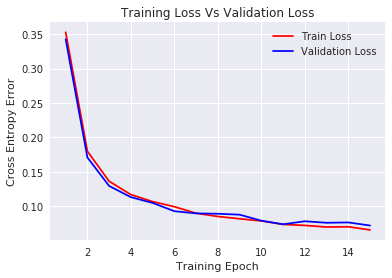

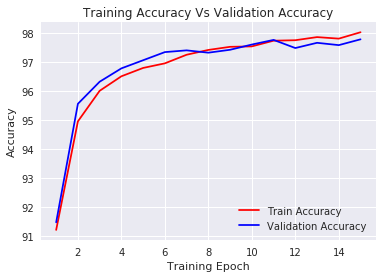

In [13]:
# buid the model c
cnn_c = build_model_c(X)

# train and evaluate the model
keep_prob_val = 0.95 # for dropout rate
num_epochs = 15
ts_loss_cnn_c, ts_acc_cnn_c, train_metric_list, val_metric_list = train_and_evaluate_model(cnn_c, 
                                                                                           keep_prob_val,
                                                                                           num_epochs)

# plot the loss curve
plot_loss_curve(train_metric_list, val_metric_list)
# plot the accuracy curve
plot_accuracy_curve(train_metric_list, val_metric_list)

# Results Summary

In [14]:
from prettytable import PrettyTable

In [15]:
ptable = PrettyTable()
ptable.title = 'Comparison of CNN Models'
ptable.field_names = ['Model', 'Architecure', 'Loss', 'Accuracy']

In [16]:
ptable.add_row(['CNN-a', '3-Convs, 2-FC', ts_loss_cnn_a, ts_acc_cnn_a, ])
ptable.add_row(['CNN-b', '4-Convs, 1-Dropout, 2-FC', ts_loss_cnn_b, ts_acc_cnn_b, ])
ptable.add_row(['CNN-c', '4-Convs, 1-BN, 1-Dropout, 2-FC', ts_loss_cnn_c, ts_acc_cnn_c, ])

In [17]:
print(ptable)

+----------------------------------------------------------------+
|                    Comparison of CNN Models                    |
+-------+--------------------------------+------------+----------+
| Model |          Architecure           |    Loss    | Accuracy |
+-------+--------------------------------+------------+----------+
| CNN-a |         3-Convs, 2-FC          | 0.08342285 |  97.47   |
| CNN-b |    4-Convs, 1-Dropout, 2-FC    | 0.13828881 |  95.82   |
| CNN-c | 4-Convs, 1-BN, 1-Dropout, 2-FC | 0.06667277 |  97.67   |
+-------+--------------------------------+------------+----------+


# Conclusion

%% HTML
<ul>
<li> All CNN models gave accuracy above 95% on test dataset</li>
<li> The deviation of train, validation curve is very less for model c i.e the model with batch 
     normalization method </li>
<li> As the number of layers increases the batch normalization model showed improved results (Model b & Model c both
    have 6 layers and the performance of c (with batch normalization) is better )</li>
</ul>